In [414]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
import random
from scipy.stats import t
import scipy.stats as st
import numpy as np
import collections
from numbers import Number
from __future__ import division
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 15, 6
use_colours = {0: "blue", 1: "red"}

In [333]:
df = pd.read_csv("fact_price_weekly_pig.csv")

In [334]:
df.date_sk = df.date_sk.astype(str)

In [335]:
df["date_sk"] = df.date_sk.apply(lambda dates: datetime.strptime(dates, '%Y%m%d').strftime('%m/%d/%Y'))

In [336]:
df['date_sk'] = pd.to_datetime(df['date_sk'])


In [337]:
df = df.set_index("date_sk")
df.price = df.price.fillna(np.mean(df.price))

In [338]:
ts = df["price"]

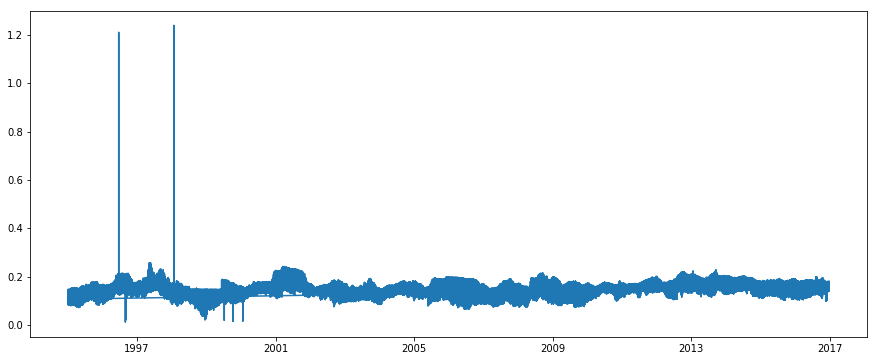

In [339]:
plt.plot(ts)


In [314]:
index = df.index.values

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

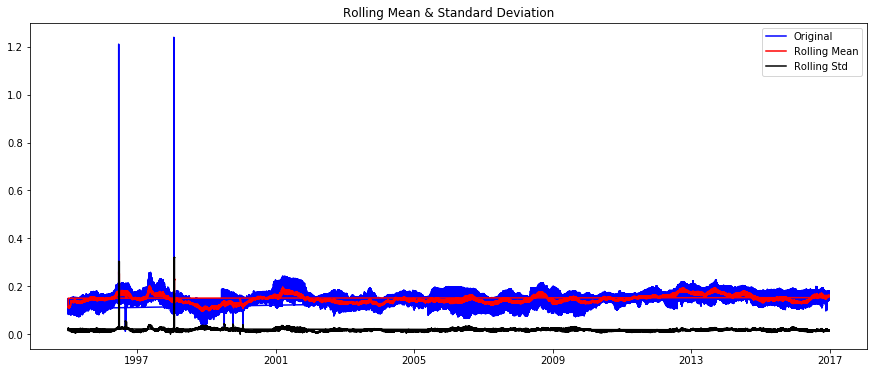

Results of Dickey-Fuller Test:
Test Statistic                    -3.083935
p-value                            0.027765
#Lags Used                        48.000000
Number of Observations Used    24017.000000
Critical Value (5%)               -2.861660
Critical Value (1%)               -3.430622
Critical Value (10%)              -2.566834
dtype: float64


In [11]:
test_stationarity(ts)

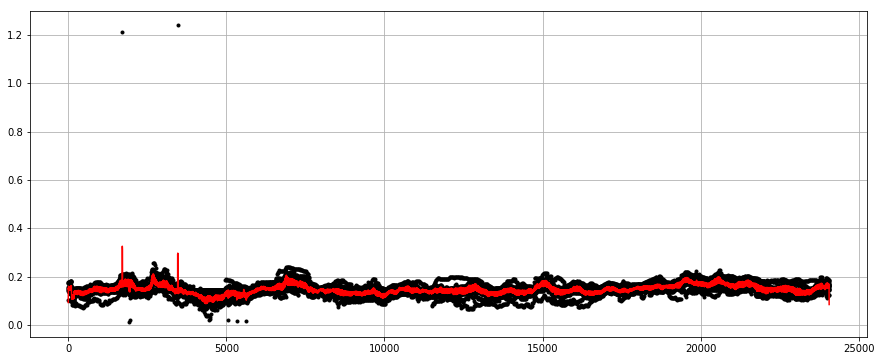

In [410]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = index
y = df.price


plt.plot(x,y,"k.")
y_av = movingaverage(y, 7)
plt.plot(x, y_av,"r")
plt.grid(True)
plt.show()

std = np.std(y_av)
events= []
ind = []
for i in range(len(df.price)):
    if df["price"][i] > y_av[i]+std:
        events.append(df["price"][i])

In [324]:
len(events)

3187

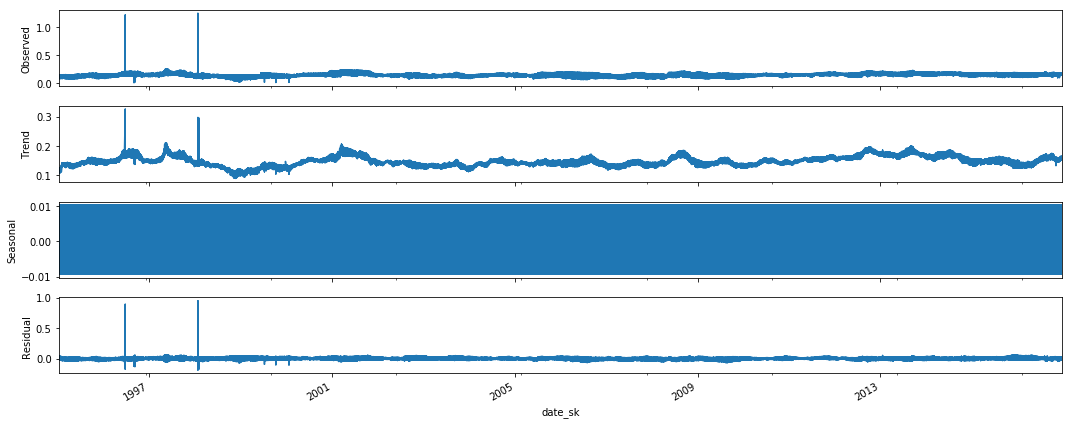

In [347]:
res = sm.tsa.seasonal_decompose(df["price"],freq=7)
resplot = res.plot()

In [345]:
random = res.resid
min_res = np.mean(random) - 3*np.std(random)
max_res = np.mean(random) + 3*np.std(random)

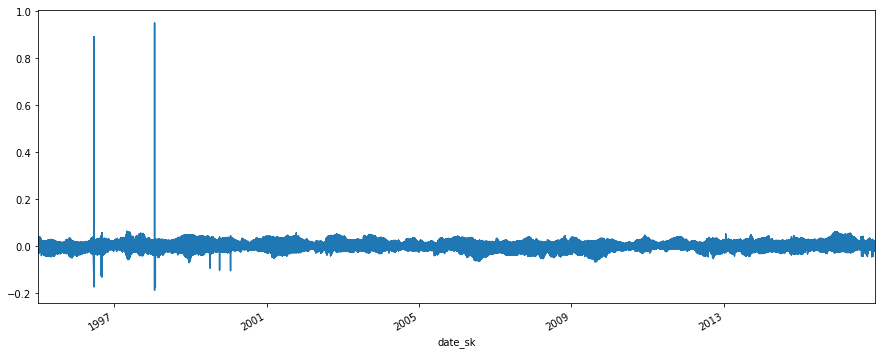

In [346]:
random.plot()

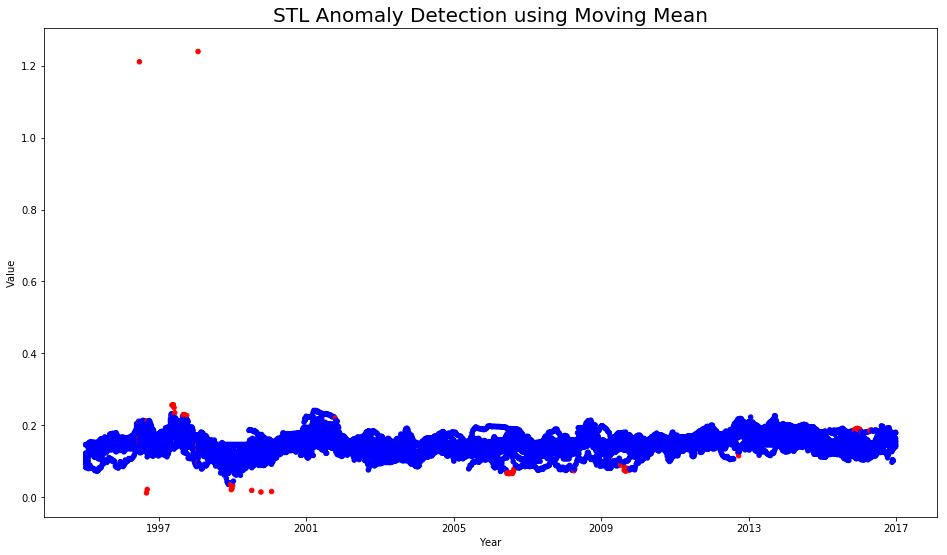

In [350]:
anomaly = []
for i in random:
    if i > max_res or i < min_res:
        anomaly.append(True)
    else:
        anomaly.append(False)

plt.figure(figsize=(16,9))
plt.scatter(random.index, df.price, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Mean", fontsize="20")

In [365]:
def running_median_numpy(seq,window_size):
    data = np.array(seq, dtype=float)
    result = []
    for i in range(1, window_size):
        window = data[:i]
        result.append(np.median(window))
    for i in xrange(len(data)-window_size+1):
        window = data[i:i+window_size]
        result.append(np.median(window))
    return result

In [366]:
random_med = running_median_numpy(df.price.values,7)

In [377]:
random_med = np.array(random_med)

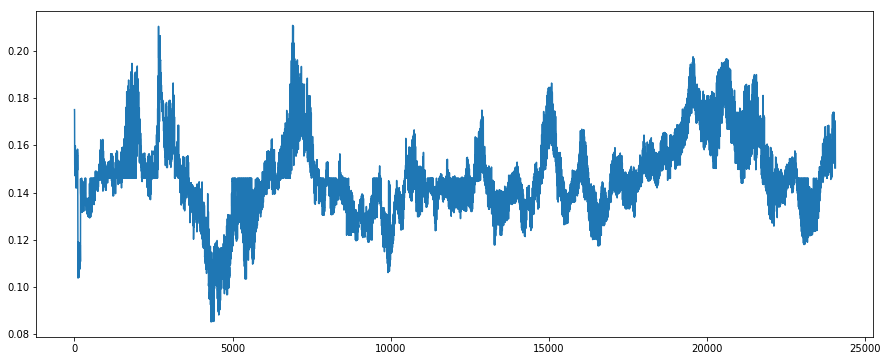

In [379]:
plt.plot(random_med)

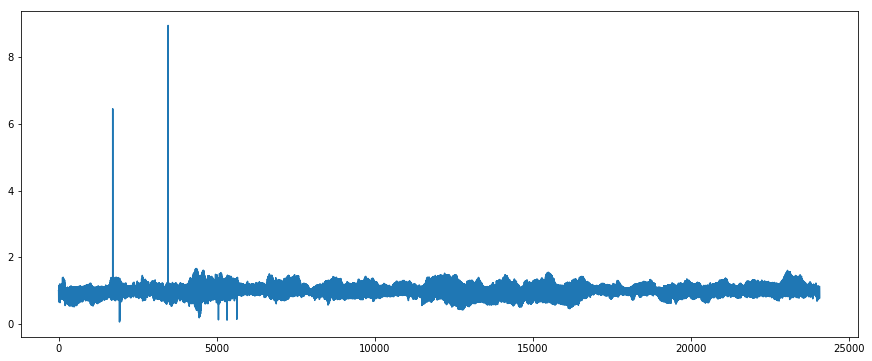

In [385]:
detrend_median = df.price.values / random_med
plt.plot(detrend_median)

In [397]:
seasonal = np.mean(detrend_median)

In [398]:
random = df.price.values / (random_med * seasonal)

In [399]:
detrend_median_wo_anom = running_median_numpy(random,3)

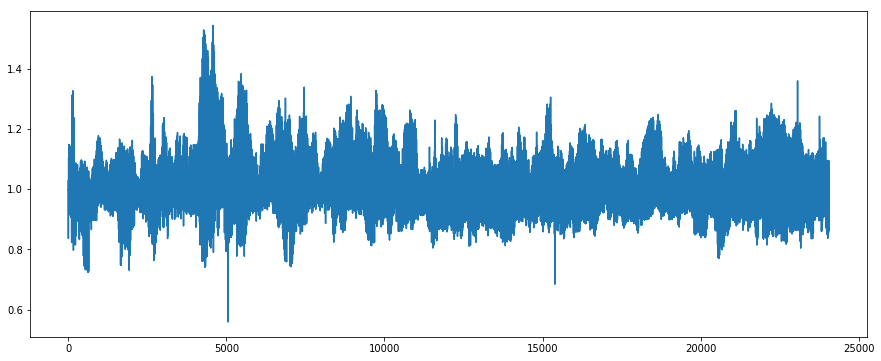

In [400]:
plt.plot(detrend_median_wo_anom)

In [407]:
min_res_med = np.mean(detrend_median_wo_anom) - 5*np.std(detrend_median_wo_anom)
max_res_med = np.mean(detrend_median_wo_anom) + 5*np.std(detrend_median_wo_anom)

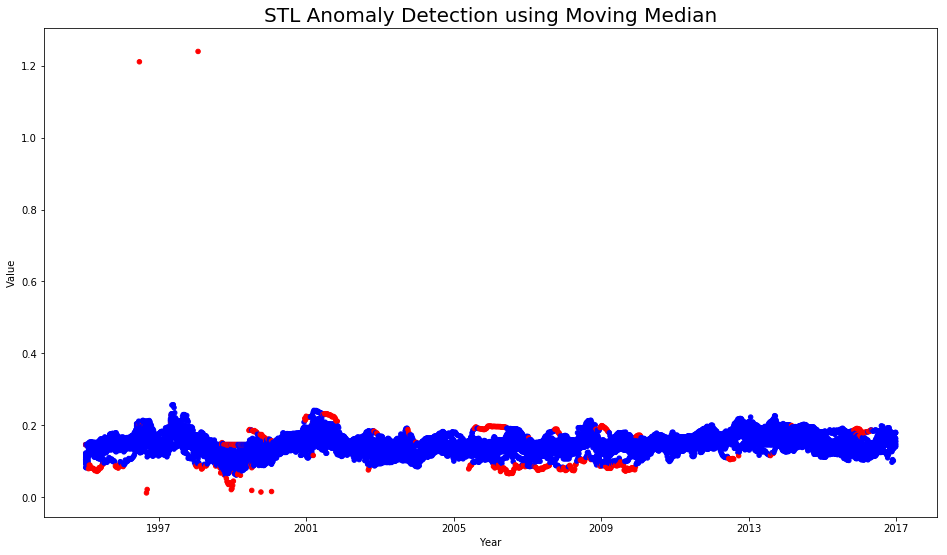

In [412]:
anomaly = []
for i in random:
    if i > max_res_med or i < min_res_med:
        anomaly.append(True)
    else:
        anomaly.append(False)

use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df.price, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Median", fontsize="20")

Since the p value is less than than the 5 % and 10 % critical value and very close to the 1 % level, the null hypothesis can be 
rejected and it can be concluded that the signal is stationary

In [209]:
df = pd.read_csv("fact_price_weekly_pig.csv")

In [210]:
np.random.seed(0)

In [211]:
df.head()

,id,date_sk,geo,unit,product,price,source
0,165712,20161203,GREAT BRITAIN,EUR/kg,Pig,0.17510,bordbia_pig_price
1,165711,20161203,UNITED KINGDOM,EUR/kg,Pig,0.17417,bordbia_pig_price
2,165710,20161203,NORTHERN IRELAND,EUR/kg,Pig,NaN,bordbia_pig_price
3,165709,20161203,EU,EUR/kg,Pig,0.15203,bordbia_pig_price
4,165708,20161203,UNITED STATES,EUR/kg,Pig,0.10121,bordbia_pig_price


In [212]:
print(df["product"].unique())
print(df["unit"].unique())
print(df["source"].unique())

['Pig']
['EUR/kg']
['bordbia_pig_price']


As can be seen these features doesn't add any variance to the model, moreover id can also be neglected. only date,geo location and the price are relevant features 

Label Encoding

In [213]:
df["geo"] = df["geo"].astype('category').cat.codes

Imputation and building the upper and lower bounds for building the Anomaly threshold

In [214]:
df.price = df.price.fillna(np.mean(df.price))
sd = np.std(df["price"])
mean = np.mean(df["price"])
# Upper Bound
X_upper = mean + sd*4
# Lower Bound
X_lower = mean - sd*4

Generating the outliers for evaluation

In [215]:
rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.9, high=X_upper*2, size=(50, 1))
X_outliers_2 = rng.uniform(low=-X_lower*1.5, high=-X_lower*2, size=(50, 1))

In [216]:
Outliers = []
Outliers.extend(X_outliers_1)
Outliers.extend(X_outliers_2)

Creating the outlier Class and inserting the anomalous data in the dataset

In [217]:
df["Actual"] = False

In [218]:
idx = df.index
for i in Outliers:
    loc = np.random.randint(0, len(df))
    df.loc[loc,"price"] = i
    df.loc[loc,"Actual"] = True

Extracting the features for Boxplot visualization

In [219]:
df['Year'] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[0:4]))
df['Month'] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[4:6]))
df['Day'] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[6:8]))

df.head()

,id,date_sk,geo,unit,product,price,source,Actual,Year,Month,Day
0,165712,20161203,8,EUR/kg,Pig,0.175100,bordbia_pig_price,False,2016,12,03
1,165711,20161203,19,EUR/kg,Pig,0.174170,bordbia_pig_price,False,2016,12,03
2,165710,20161203,14,EUR/kg,Pig,0.146117,bordbia_pig_price,False,2016,12,03
3,165709,20161203,4,EUR/kg,Pig,0.152030,bordbia_pig_price,False,2016,12,03
4,165708,20161203,20,EUR/kg,Pig,0.101210,bordbia_pig_price,False,2016,12,03


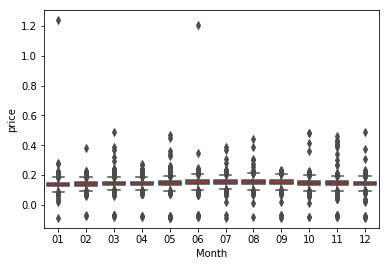

In [220]:
import seaborn as sns

ax = sns.boxplot(x="Month", y="price", data=df,color="red")
#ax = sns.swarmplot(x="Month", y="price", data=df_year, color=".25")

We can see some pretty obvious outliers in Month 1 and 6

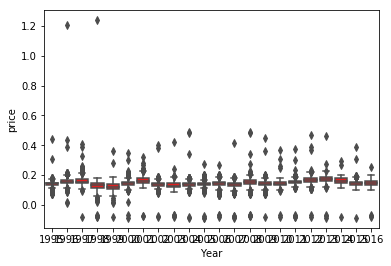

In [221]:
ax = sns.boxplot(x="Year", y="price", data=df,color="red")

The visualization neatly describes the anomalous features each year

Like Discussed earlier, only the date, geo and the price fields are relevant with respect to the anomaly detection and hence only including those

In [222]:
df_corr = df.corr()
print(df_corr)

               id   date_sk       geo     price    Actual
id       1.000000  0.576672  0.000261  0.097610 -0.001970
date_sk  0.576672  1.000000  0.000000  0.144838  0.007115
geo      0.000261  0.000000  1.000000  0.028432  0.001813
price    0.097610  0.144838  0.028432  1.000000 -0.027865
Actual  -0.001970  0.007115  0.001813 -0.027865  1.000000


In [223]:
from sklearn import preprocessing
df = df.dropna()
df_new = df[["geo","price"]]
#df_new = df["price"]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [224]:
len(df_scaled)

24066

Resizing the array for training autoencoder neural network 

In [225]:
array = np.array(df_scaled)
row,column = array.shape
array = array.reshape((1,row,column))

In [226]:
array.shape

(1, 24066, 2)

In [227]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)

In [228]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

In [229]:
# Just compute the distance before learning (show be very bad !)

test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [230]:
df["naivedist"] = naivedist

In [231]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [232]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [233]:
encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))


In [234]:
dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [235]:
df["dist"] = dist

In [236]:
df_index = df.sort(columns="price")
df_index = df_index.reset_index()
df_index = df_index[["index","price"]]

In [240]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def doubleMADsfromMedian(y,thresh=4):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# Valid Only for Non Stationary time series
def anomaly_detector2(feature,Z=3):
    results = []
    diff_X = []
    index = []
    X= np.sort(feature.price)
    Y = feature[feature.columns[0]]
    for i in range(len(X)):
        if i ==0:
            value = X[i]
        else:
            value = X[i] - X[i-1]
                
        diff_X.append(value)
    X_mean = np.mean(diff_X)
    X_std = np.std(diff_X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    j = 0
    for i in diff_X:
        if X_upper < i or X_lower > i:
            results.append(True)
            index.append(Y[j])
        else:
            results.append(False)
        j = j + 1
    return results,index

# Model for stationary time series
def anomaly_detector1(feature,Z=3):
    results = []
    X= np.sort(feature)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in feature:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results


In [241]:
results_mad_AE = mad_based_outlier(dist)
results_mad_Normal = mad_based_outlier(df.price)
results_per = percentile_based_outlier(df.price)
results_per_AE = percentile_based_outlier(dist)
results_doublemad_AE = doubleMADsfromMedian(dist)
results_doublemad_Normal = doubleMADsfromMedian(df.price)
results_AD = anomaly_detector1(df.price)
results_AD_AE = anomaly_detector1(dist)

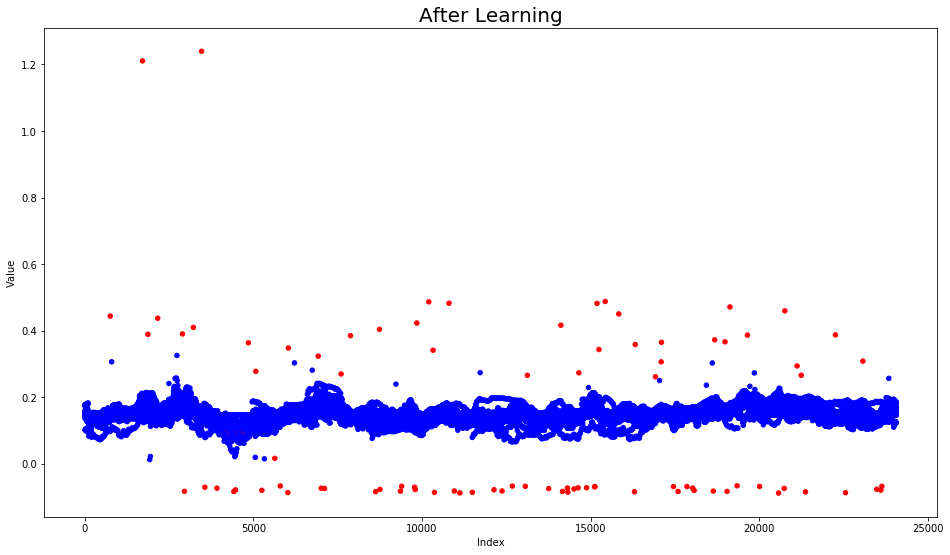

In [242]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_mad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

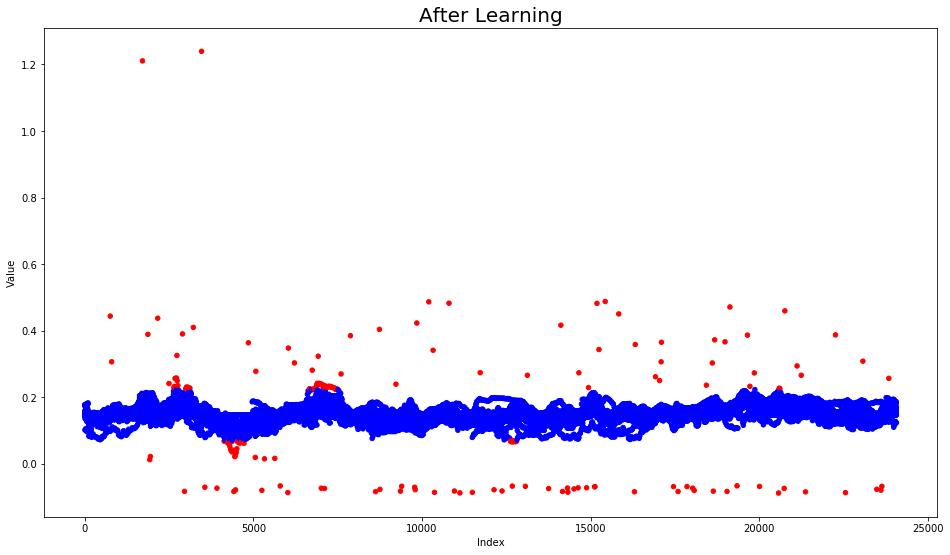

In [243]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_mad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

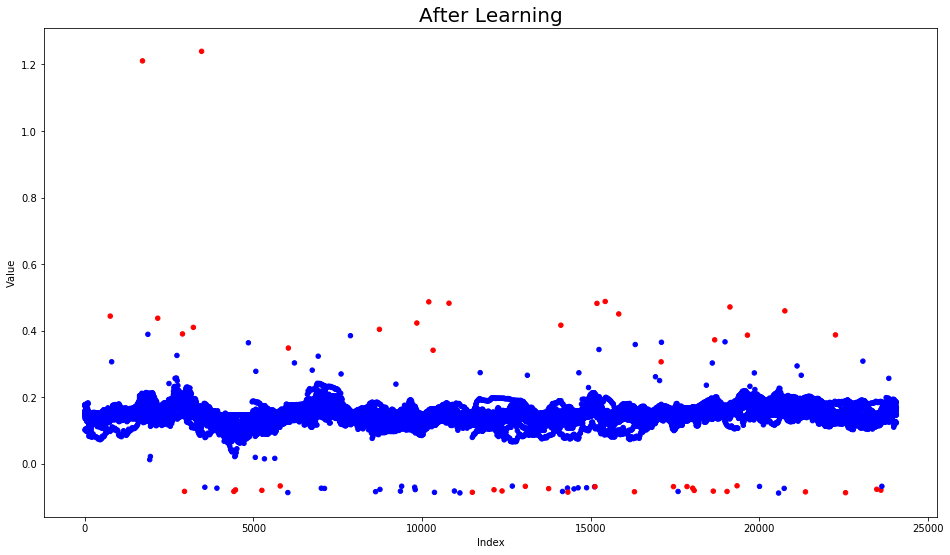

In [244]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_doublemad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

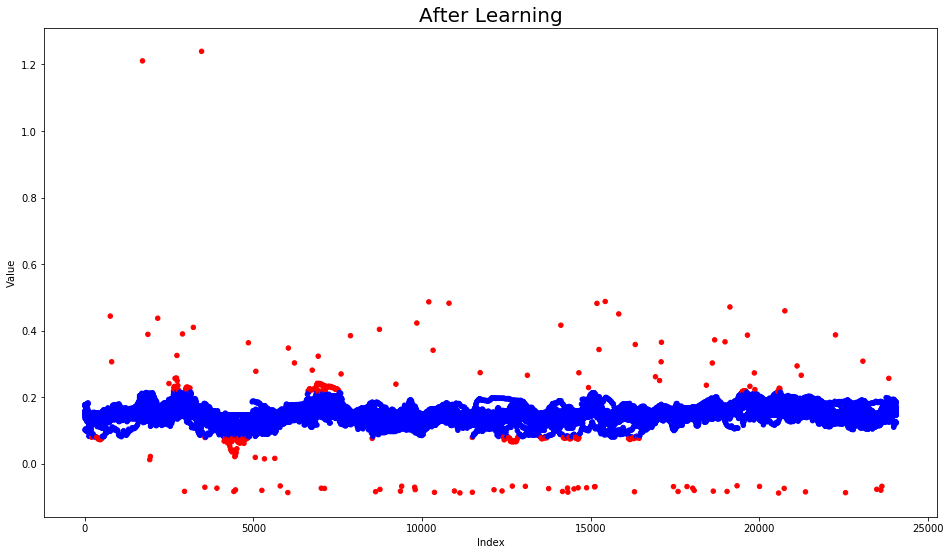

In [245]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_doublemad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

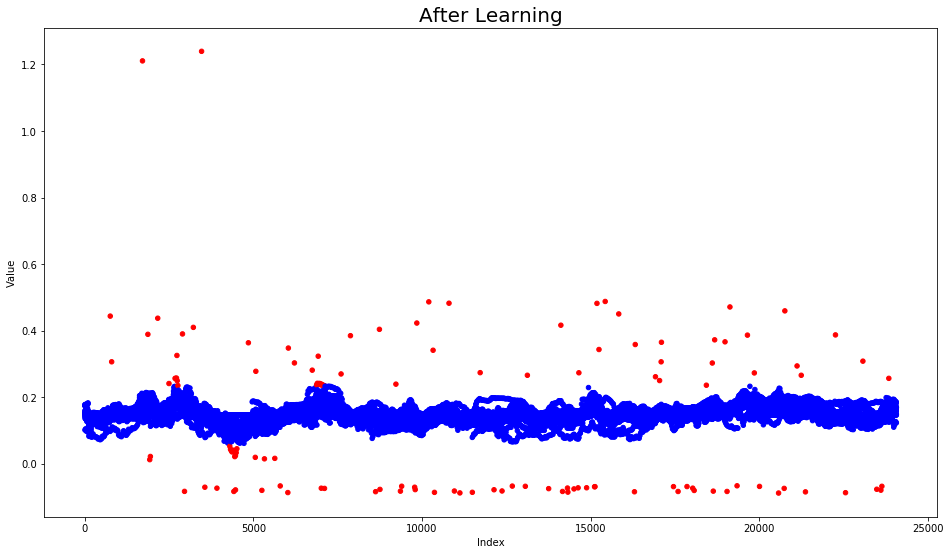

In [246]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_AD], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

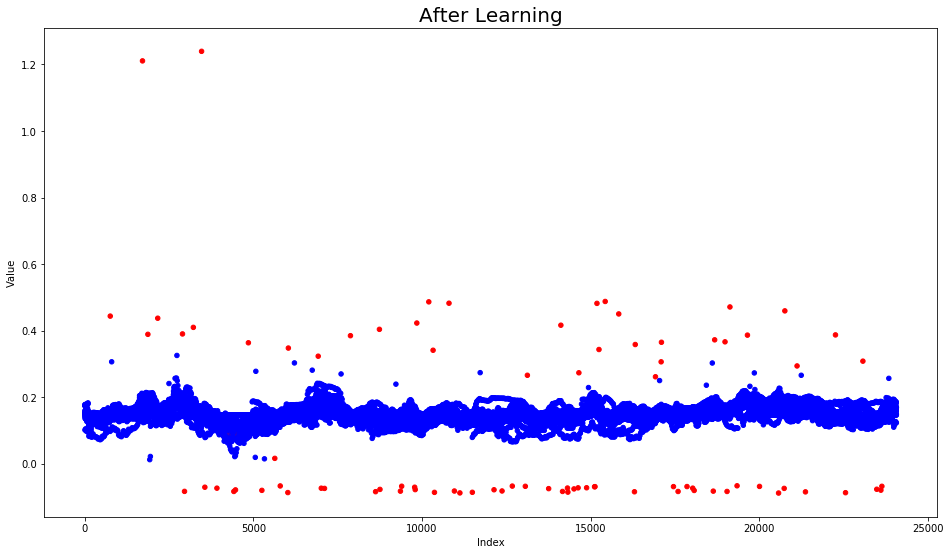

In [247]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_AD_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

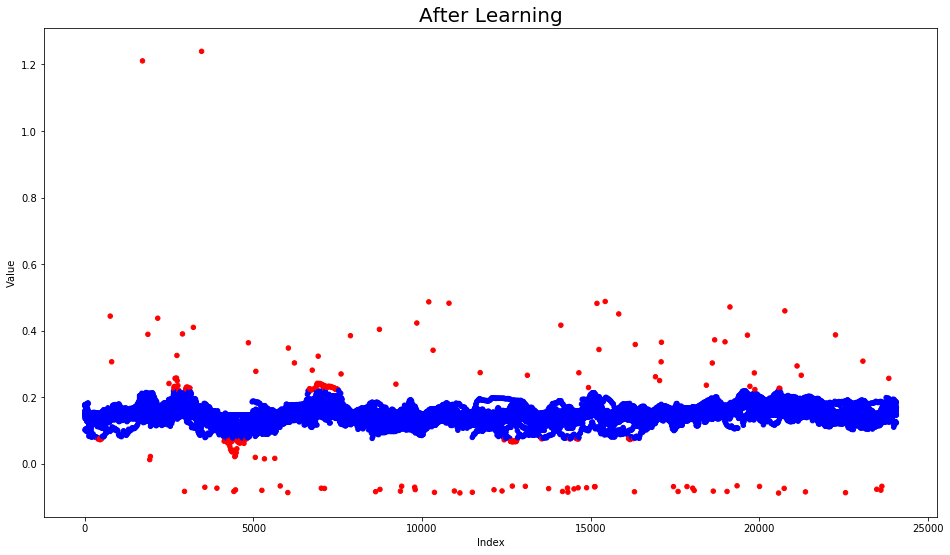

In [248]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_per], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

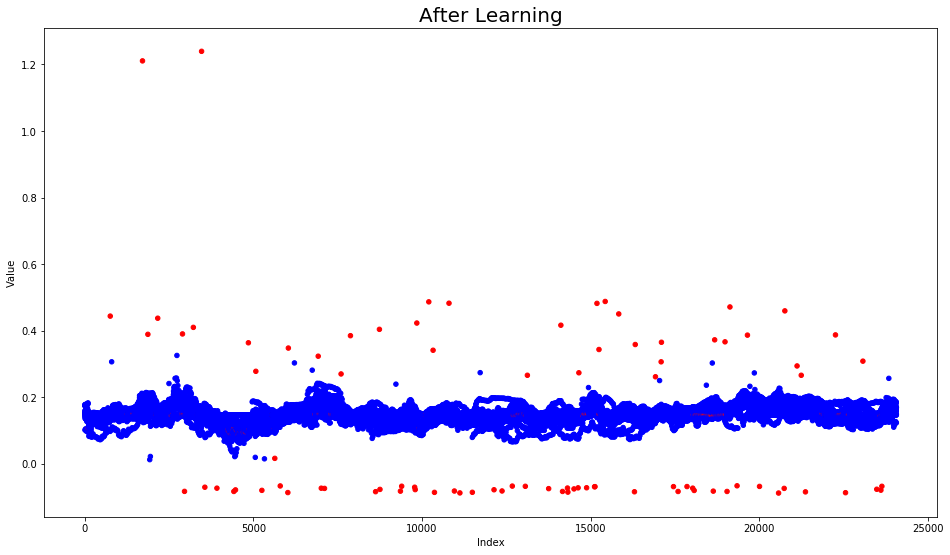

In [249]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in results_per_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [250]:
df["Outlier_MAD_AE"] = results_mad_AE
df["Outlier_MAD_Normal"] = results_mad_Normal 
df["Outlier_PER"] = results_per
df["Outlier_PER_AE"] = results_per_AE
df["Outlier_DoubleMAD_AE"] = results_doublemad_AE
df["Outlier_DoubleMAD_Normal"] = results_doublemad_Normal
df["Outlier_AD"] = results_AD
df["Outlier_AD_AE"] = results_AD_AE

In [278]:
cm=confusion_matrix(df.Actual,df.Outlier_MAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_MAD_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.99846256129
Precision of MAD based Outlier detection using Autoencoders is :0.86
Cohen's Kappa: 0.822195873238


In [279]:
cm=confusion_matrix(df.Actual,df.Outlier_DoubleMAD_AE)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_DoubleMAD_AE)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.997589960941
Precision of MAD based Outlier detection without Autoencoders is:0.44
Cohen's Kappa: 0.601696820829


In [280]:
cm=confusion_matrix(df.Actual,df.Outlier_AD_AE)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_AD_AE)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.998836532868
Precision of MAD based Outlier detection without Autoencoders is:0.83
Cohen's Kappa: 0.85508657627


In [281]:
cm=confusion_matrix(df.Actual,df.Outlier_PER_AE)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_PER_AE)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.992936092413
Precision of MAD based Outlier detection without Autoencoders is:0.86
Cohen's Kappa: 0.49998362293


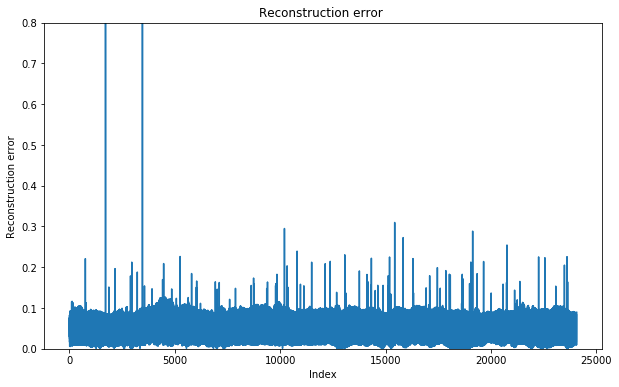

In [257]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

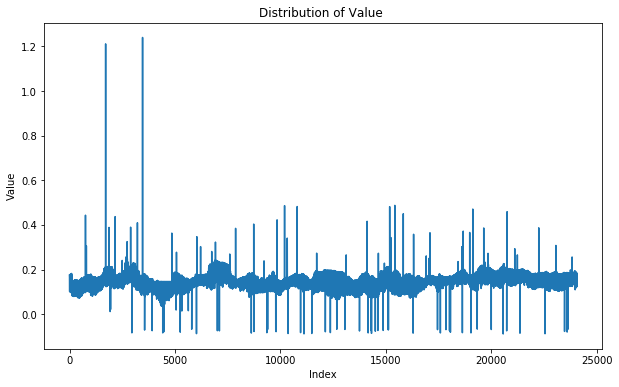

In [258]:
value = np.array(df["price"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")

In [272]:
from sklearn.ensemble import IsolationForest

X_train,X_test = train_test_split(df_new,test_size=0.2)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"price"] = i
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test[['geo','price']]
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [273]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True


In [274]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)

In [275]:
cm

array([[4670,   45],
       [   6,   93]])

In [276]:
coh = cohen_kappa_score(X_test.Actual,y_pred_test)
print(coh)

0.779530062123


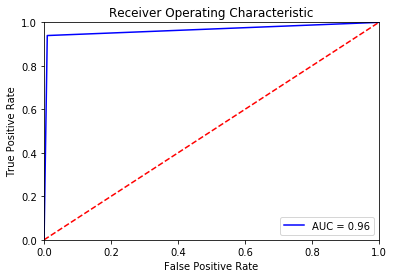

In [282]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [283]:
print("Accuracy of Isolation Forest :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Isolation Forest:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))

Accuracy of Isolation Forest :0.992936092413
Precision of Isolation Forest:0.86


In [284]:
X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub.columns.values[0] = "new_index"
X_test_sub["Actual"] = X_test["Actual"]

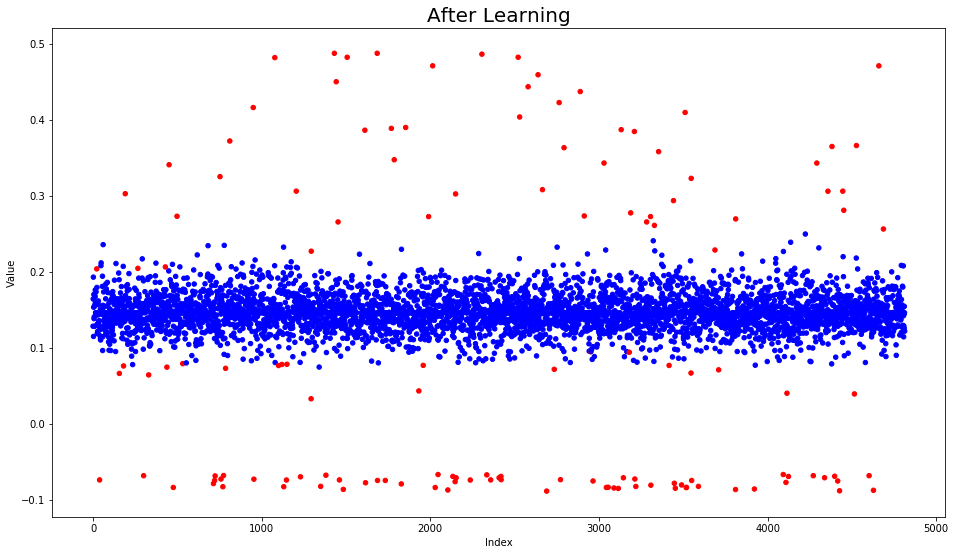

In [285]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["price"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")